In [44]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import itertools
from jax.scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
sigma2 = 0.5**2

L = 3.0


a = 0.5
b = 0.5

v_max = 1.5
p_max = 1 # rho_max cannot be learned Susana's paper

In [3]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.mish(layer(x))
        
        x = self.layers[-1](x)
        return x

In [4]:
# Extracting the weights
def extract_weights(model):
    weights = []
    for layer in model.layers:
        weights.append(layer.weight.flatten())
        weights.append(layer.bias.flatten())
    return jnp.concatenate(weights)

In [15]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)

input_dim = 'scalar'
output_dim = 'scalar'

model = MLP(model_key, input_dim=input_dim, hidden_dims=3, n_layers=3, output_dim=output_dim)

In [24]:
# Initialize the hypermodel with multiple hidden layers and scalar output layer
hyper_model_key = jax.random.PRNGKey(1)

hyper_input_dim = 'scalar'
hyper_output_dim = len(extract_weights(model))

hypermodel = MLP(hyper_model_key, input_dim=hyper_input_dim, hidden_dims=hyper_output_dim, n_layers=3, output_dim=hyper_output_dim)

In [25]:
vec = extract_weights(model)

In [26]:
# Function to set weights from an array
def set_weights(model, weights_array):
    index = 0
    for i, layer in enumerate(model.layers):
        weight_shape = layer.weight.shape
        bias_shape = layer.bias.shape
        weight_size = jnp.prod(jnp.array(weight_shape))
        bias_size = jnp.prod(jnp.array(bias_shape))
        
        # Extract the weights and biases from the array
        new_weights = weights_array[index:index+weight_size].reshape(weight_shape)
        index += weight_size
        new_biases = weights_array[index:index+bias_size].reshape(bias_shape)
        index += bias_size
        
        # Assign the extracted values to the model's layer using equinox.tree_at
        model = eqx.tree_at(lambda m: m.layers[i].weight, model, replace=new_weights)
        model = eqx.tree_at(lambda m: m.layers[i].bias, model, replace=new_biases)
        
    return model

In [27]:
len(vec)

34

In [28]:
model = set_weights(model, vec)

In [29]:
extract_weights(model)

Array([-0.91209555,  0.24479628,  0.02537847, -0.9001248 ,  0.85935235,
        0.634711  , -0.31324172,  0.24022485,  0.4971223 ,  0.4264481 ,
       -0.01427579, -0.1536352 ,  0.16919418, -0.21148497,  0.32536203,
       -0.41577727, -0.36301067,  0.15959825,  0.33319476,  0.28958818,
        0.11851561, -0.25396532,  0.12596212, -0.344029  ,  0.16856718,
        0.1850597 ,  0.54782647, -0.11685099,  0.11037988,  0.28751087,
        0.36201587,  0.4805637 , -0.24962188, -0.150343  ], dtype=float32)

In [30]:
bb = hypermodel(1)

In [31]:
model = set_weights(model, bb)

In [32]:
jnp.sum((bb-bb)**2)

Array(0., dtype=float32)

In [33]:
def hyperloss(hypermodel, input, real):

    estimated = hypermodel(input)

    return jnp.sum((estimated-real)**2)


In [34]:
#@eqx.filter_value_and_grad
def loss(model, v_max, sigma2, L, a, b, steps=50):

    x_flat = jnp.linspace(0, L, steps)
    inputs = jnp.concat([x_flat, jnp.array([0.0]), jnp.array([L])])
    

    rho, grad = jax.vmap(jax.value_and_grad(model))(inputs)
    hess = jax.vmap(jax.hessian(model))(inputs)

    dp_dx = grad
    d2p_dx2 = hess

    # PDE Loss
    pde_loss = sigma2*d2p_dx2 - dp_dx*(v_max*(1-2*rho))

    # in loss
    in_loss = sigma2*dp_dx[-2] - rho[-2]*v_max*(1-rho[-2]) + a*(1-rho[-2])

    # out loss
    out_loss = -sigma2*dp_dx[-1] + rho[-1]*v_max*(1-rho[-1]) - b*rho[-1]

    return jnp.average(pde_loss**2) + in_loss**2 + out_loss**2



In [35]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)

input_dim = 'scalar'
output_dim = 'scalar'

model = MLP(model_key, input_dim=input_dim, hidden_dims=3, n_layers=3, output_dim=output_dim)

In [36]:
# Initialize the hypermodel with multiple hidden layers and scalar output layer
hyper_model_key = jax.random.PRNGKey(1)

hyper_input_dim = 'scalar'
hyper_output_dim = len(extract_weights(model))

hypermodel = MLP(hyper_model_key, input_dim=hyper_input_dim, hidden_dims=hyper_output_dim, n_layers=3, output_dim=hyper_output_dim)

In [37]:
# Optimizer definition
lr = 10e-4
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model)

In [38]:
# Optimizer definition
hyper_lr = 10e-3
hyper_optimizer = optax.adam(learning_rate=lr)
hyper_opt_state = optimizer.init(hypermodel)

In [39]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, L, v_max, sigma2, a, b, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, v_max, sigma2, L, a, b) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [40]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def hyper_train_step(model, opt_state, input, real):
    loss_value, grads = jax.value_and_grad(hyperloss)(hypermodel, input, real) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [41]:
# Create a function to run multiple training steps using jax.lax.scan
def train_multiple_steps(num_steps, model, opt_state, input, real):
    def step(carry, _):
        model, opt_state = carry
        model, opt_state, loss_value = hyper_train_step(model, opt_state, input, real)
        return (model, opt_state), loss_value

    (model, opt_state), loss_values = jax.lax.scan(step, (model, opt_state), None, length=num_steps)
    return model, opt_state, loss_values

In [42]:
v_array = jnp.linspace(0.5,2,20)

In [43]:
# Training loop
num_epochs = 5000
losses = []


for v in v_array:
    v_max = v
    model = MLP(model_key, input_dim=input_dim, hidden_dims=3, n_layers=3, output_dim=output_dim)
    # Optimizer definition
    lr = 10e-4
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(model)
    

    for epoch in range(num_epochs):
        
        model, opt_state, loss_value = train_step(model, opt_state, L, v_max, sigma2, a, b, steps=200)

        if epoch % 100 == 0:
            losses.append(loss_value)
            print(f"Epoch {epoch}, Loss: {loss_value}")
            for hyper_epoch in range(100):
                real = extract_weights(model)
                #hypermodel, hyper_opt_state, hyper_loss_values = train_multiple_steps(100, hypermodel, hyper_opt_state, v_max, real)
                hypermodel, hyper_opt_state, hyper_loss_value = hyper_train_step(hypermodel, hyper_opt_state, v_max, real)
            print(hyper_loss_value)
            
        # if epoch % 1000 == 0:
        #     lr *= 0.4
        #     optimizer = optax.adam(learning_rate=lr)
        #     opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate

    

    



Epoch 0, Loss: 0.5582554340362549
6.131171
Epoch 100, Loss: 0.23698021471500397
6.003593
Epoch 200, Loss: 0.0819472074508667
6.7352524
Epoch 300, Loss: 0.026544682681560516
7.946637
Epoch 400, Loss: 0.008552704006433487
9.128874
Epoch 500, Loss: 0.00316964671947062
9.763002
Epoch 600, Loss: 0.0016408130759373307
10.058638
Epoch 700, Loss: 0.001161478809081018
10.202201
Epoch 800, Loss: 0.000999694224447012
10.256554
Epoch 900, Loss: 0.0009381248382851481
10.256892
Epoch 1000, Loss: 0.0009079309529624879
10.225565
Epoch 1100, Loss: 0.0008872305625118315
10.177365
Epoch 1200, Loss: 0.0008694419520907104
10.122251
Epoch 1300, Loss: 0.0008528500329703093
10.066912
Epoch 1400, Loss: 0.0008371873409487307
10.015721
Epoch 1500, Loss: 0.0008225525380112231
9.971281
Epoch 1600, Loss: 0.0008090479532256722
9.934744
Epoch 1700, Loss: 0.0007966658449731767
9.906146
Epoch 1800, Loss: 0.0007852758863009512
9.884762
Epoch 1900, Loss: 0.0007746723131276667
9.869495
Epoch 2000, Loss: 0.0007646360900253

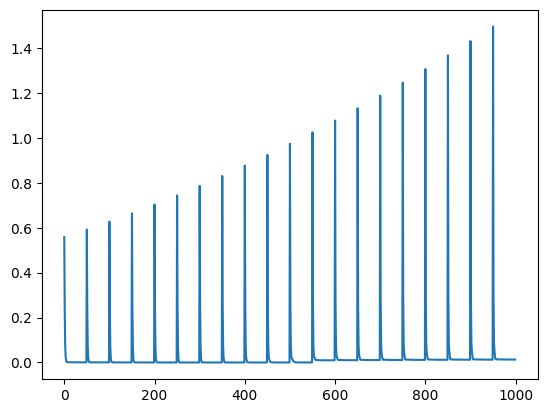

In [45]:
plt.plot(losses)
plt.show()